In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy

from database_credentials import get_database_url
from datetime import datetime, timedelta

In [2]:
def get_week_n_sell_data(week, connection):
    """Get the sell data for a given week
    
    Args:
        week (int): week number
        connection (sqlalchemy connection): MySQL database connection  
    
    Returns:
        week_n_sell_data (dataframe): 
            turnip selling data for a given week
    """
    
    first_week = datetime.strptime('2020-04-12', '%Y-%m-%d')
    week_lower_bound = first_week + timedelta(days=(7 * (week - 1)))
    week_lower_bound = datetime.strftime(week_lower_bound, '%Y-%m-%d')
    week_upper_bound = first_week + timedelta(days=(7 * week))
    week_upper_bound = datetime.strftime(week_upper_bound, '%Y-%m-%d')
    
    query = '''
        SELECT 
            *
        FROM 
            turnip.sell_data
        WHERE
            datetime_observed >= %(lower_bound)s AND
            datetime_observed < %(upper_bound)s;
    '''
    parameters = {
        'lower_bound': week_lower_bound,
        'upper_bound': week_upper_bound
    }
    week_n_sell_data = pd.read_sql(query, connection, params=parameters)
    
    return week_n_sell_data

def drop_incomplete_weeks(data):
    """Drop data with any missing selling prices
    
    Args:
        data (dataframe): 
            contains turnip selling prices loaded into 
            a dataframe using get_week_n_sell_data
    
    Returns:
        data (dataframe):
            contains turnip selling prices for the entire week
    """
    
    table = pd.pivot_table(
        data, 
        values='price', 
        index=['user_id', 'island_id'], 
        columns=['datetime_observed']
    )
    table.dropna(inplace=True)

    data = table.reset_index().melt(
        id_vars=['user_id', 'island_id'], 
        value_name='price'
    )
    return data

def plot_sell_data(data, plot_individuals=True):
    """Plot the sell price data for each individual or overall
    
    Args:
        data (dataframe): contains selling prices of turnips
        plot_individuals (bool): plot individual or overall data
    
    """
    
    earliest_sell_date = data['datetime_observed'].min()
    latest_sell_date = data['datetime_observed'].max() 
    
    user_island_id = zip(data['user_id'], data['island_id'])
    data['user_island_id'] = list(user_island_id)
    
    if (plot_individuals):
        hue='user_island_id'
    else:
        hue=None
    
    plt.figure(figsize=(12, 6))
    sell_price_plot = sns.lineplot(
        x='datetime_observed', 
        y='price', 
        data=data, 
        hue=hue, 
        legend=False
    )
    
    title='Date vs Turnip Selling Price {0} to {1}'.format(
        datetime.strftime(earliest_sell_date, '%Y-%m-%d'), 
        datetime.strftime(latest_sell_date, '%Y-%m-%d')
    )
    sell_price_plot.set(
        title=title,
        xlabel='Date',
        ylabel='Price'
    )
    
    plt.xlim(earliest_sell_date, latest_sell_date)
    plt.show()

In [3]:
plt.style.use('ggplot')
sns.set_style('white')

In [4]:
database_url = get_database_url()
engine = sqlalchemy.create_engine(database_url)
connection = engine.connect()

In [5]:
buy_data = pd.read_sql_table('buy_data', connection)
sell_data = pd.read_sql_table('sell_data', connection)

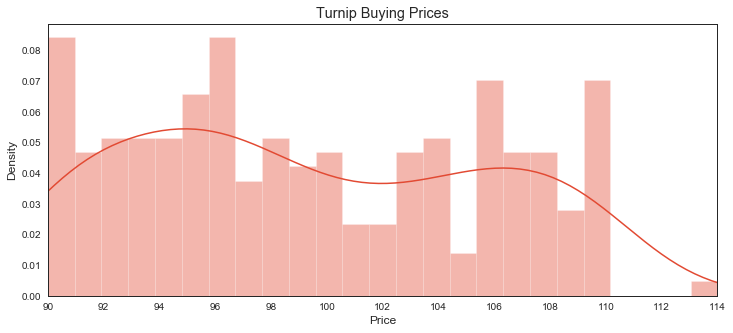

Buying Prices Description:
count    222.000000
mean      99.387387
std        6.433328
min       90.000000
25%       94.000000
50%       98.000000
75%      106.000000
max      114.000000
Name: price, dtype: float64



In [6]:
buy_prices = buy_data['price']
buy_price_describe = buy_prices.describe()

min_buy_price = buy_price_describe['min']
max_buy_price = buy_price_describe['max']

num_buy_bins = int(max_buy_price - min_buy_price + 1)
buy_dist_xticks = np.arange(min_buy_price, max_buy_price + 1, 2)

plt.figure(figsize=(12, 5))
buy_price_distribution = sns.distplot(buy_prices, bins=num_buy_bins)
buy_price_distribution.set(
    title='Turnip Buying Prices',
    xlabel='Price',
    ylabel='Density'
)
plt.xlim(min_buy_price, max_buy_price)
plt.xticks(buy_dist_xticks)
plt.show()

print("Buying Prices Description:\n{0}\n".format(buy_price_describe))

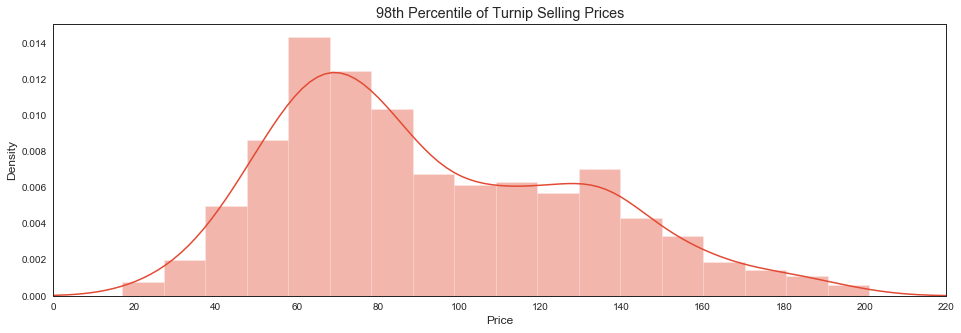

Selling Prices:
count    1749.000000
mean       98.177816
std        56.695792
min        17.000000
25%        65.000000
50%        85.000000
75%       124.000000
90%       150.000000
98%       201.040000
max       589.000000
Name: price, dtype: float64



In [7]:
sell_prices = sell_data['price']
sell_percentiles = [0.25, 0.50, 0.75, 0.90, 0.98]
sell_price_describe = sell_prices.describe(percentiles=sell_percentiles)

min_sell_price = sell_price_describe['min']
sell_price_98_percentile = sell_price_describe['98%']

# mask outlying price data above 98th percentile 
outlier_mask = sell_prices <= sell_price_98_percentile

num_sell_bins = int(round((sell_price_98_percentile - min_sell_price) / 10, 0))

sell_dist_tick_step = round(num_sell_bins, -1)
sell_dist_tick_max = (math.ceil(sell_price_98_percentile))
sell_dist_tick_max = sell_dist_tick_max + sell_dist_tick_step
sell_dist_xticks = np.arange(0, sell_dist_tick_max, sell_dist_tick_step)
                      
plt.figure(figsize=(16, 5))                 
sell_price_distribution = sns.distplot(
    sell_prices[outlier_mask], 
    bins=num_sell_bins
)
sell_price_distribution.set(
    title='98th Percentile of Turnip Selling Prices',
    xlabel='Price',
    ylabel='Density'
)
plt.xlim(0, round(sell_price_98_percentile, -1))
plt.xticks(sell_dist_xticks)
plt.show()

print("Selling Prices:\n{0}\n".format(sell_price_describe))

,datetime_observed,2020-04-13 00:00:00,2020-04-13 12:00:00,2020-04-14 00:00:00,2020-04-14 12:00:00,2020-04-15 00:00:00,2020-04-15 12:00:00,2020-04-16 00:00:00,2020-04-16 12:00:00,2020-04-17 00:00:00,2020-04-17 12:00:00,...,2020-04-28 00:00:00,2020-04-28 12:00:00,2020-04-29 00:00:00,2020-04-29 12:00:00,2020-04-30 00:00:00,2020-04-30 12:00:00,2020-05-01 00:00:00,2020-05-01 12:00:00,2020-05-02 00:00:00,2020-05-02 12:00:00
user_id,island_id,,,,,,,,,,,,,,,,,,,,,
Aaron,Moonstone,68.0,81.0,77.0,132.0,107.0,143.0,148.0,145.0,55.0,51.0,...,50.0,45.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adam,Key Largo,69.0,61.0,89.0,104.0,NaN,NaN,NaN,54.0,47.0,127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aika,Erijima,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,109.0,127.0,139.0,67.0,61.0,112.0,130.0,72.0,67.0,61.0


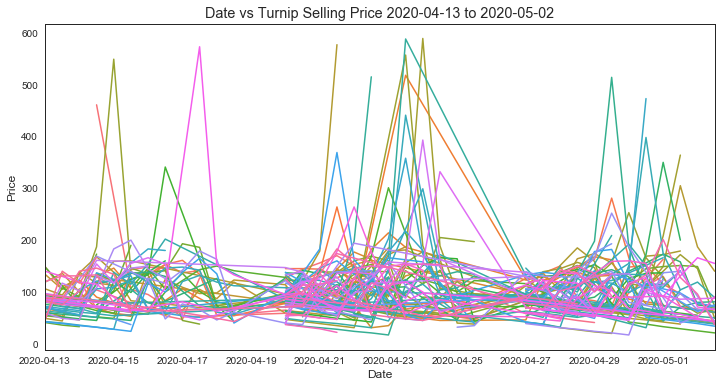

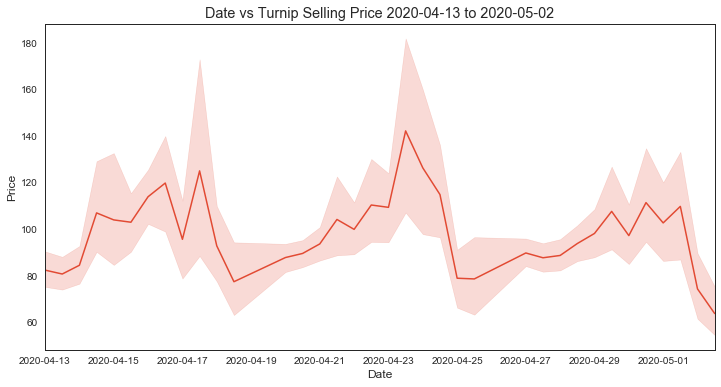

In [8]:
sell_data_pivot = pd.pivot_table(
    sell_data, 
    values='price', 
    index=['user_id', 'island_id'], 
    columns=['datetime_observed']
)

display(sell_data_pivot.head(3))
plot_sell_data(data=sell_data, plot_individuals=True)
plot_sell_data(data=sell_data, plot_individuals=False)

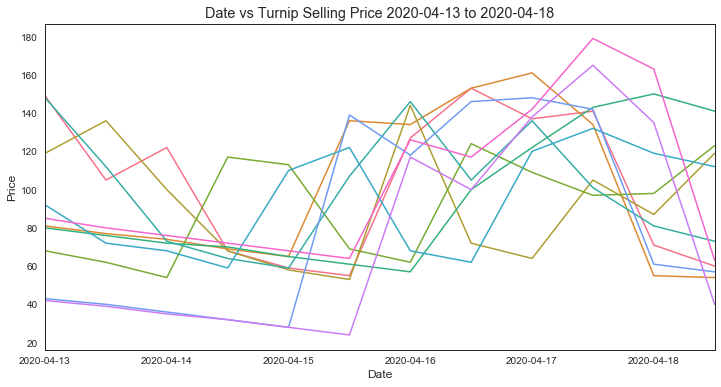

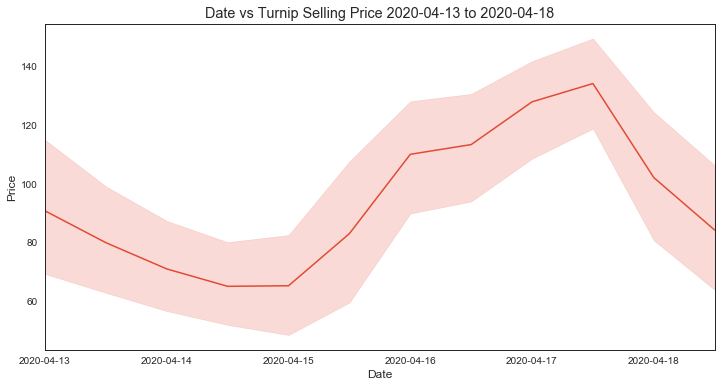

In [9]:
week1_sell_data = get_week_n_sell_data(week=1, connection=connection)
week1_sell_data = drop_incomplete_weeks(week1_sell_data)

plot_sell_data(week1_sell_data, True)
plot_sell_data(week1_sell_data, False)

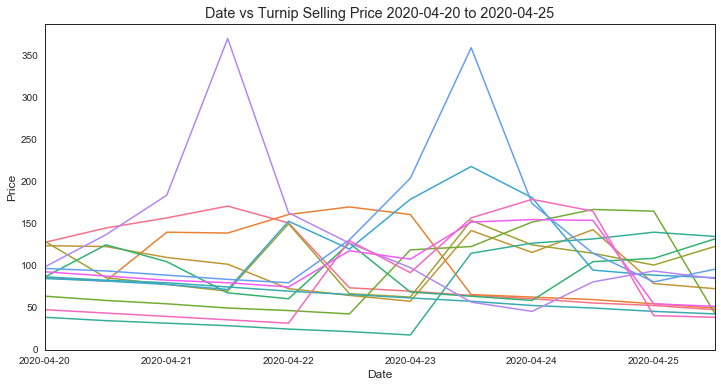

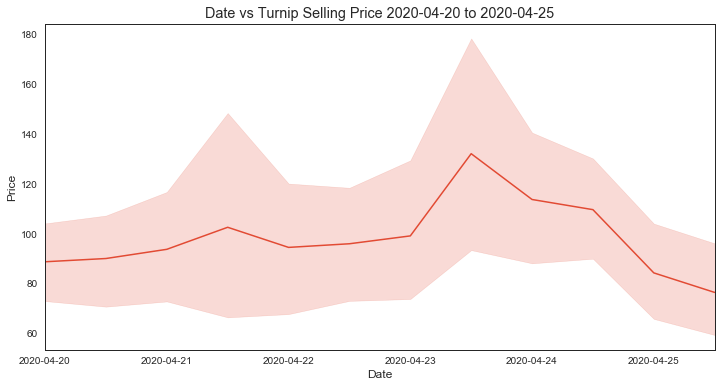

In [10]:
week2_sell_data = get_week_n_sell_data(week=2, connection=connection)
week2_sell_data = drop_incomplete_weeks(week2_sell_data)

plot_sell_data(week2_sell_data, True)
plot_sell_data(week2_sell_data, False)

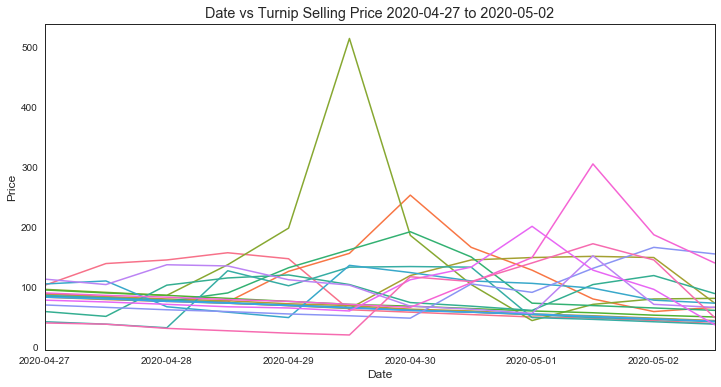

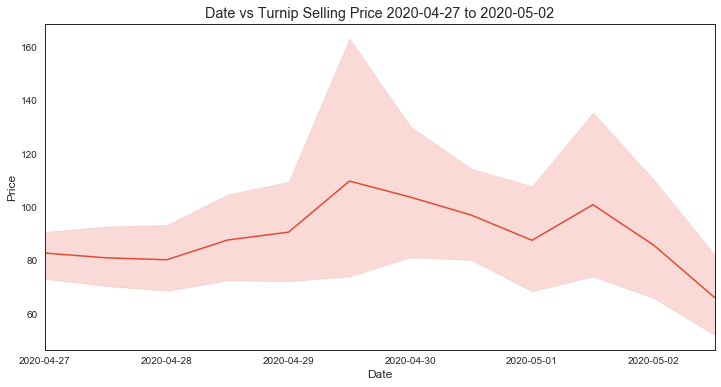

In [11]:
week3_sell_data = get_week_n_sell_data(week=3, connection=connection)
week3_sell_data = drop_incomplete_weeks(week3_sell_data)

plot_sell_data(week3_sell_data, True)
plot_sell_data(week3_sell_data, False)

In [ ]:
connection.close()
engine.dispose()